# Exploring the relationship between FIFA Attributes and team performance
<i>By Diego Ramallo</i>

In this notebook, I'll be looking at data from the [Kaggle European Soccer Database]( https://www.kaggle.com/hugomathien/soccer). See an interactive version of this notebook [here.](https://nbviewer.jupyter.org/github/ramalldf/data_science/blob/master/fifa_clubs_analysis.ipynb) 

<img src="https://dl.dropboxusercontent.com/u/59776078/data_science/data_science/pixabay_fifa_banner.jpg" alt="Drawing" style="width: 600px;"/>

[comment]: <> (Open source image: https://pixabay.com/en/man-fan-person-football-soccer-290186/)

One thing that I've always wondered about the FIFA games series is how accurate their team metrics are compared to soccer in real life. Thus, I decided to find what attributes have are the best predictors for team performance (winning percentage).

In this analysis, I'll consolidate FIFA data with data from the Match results table to see if there's a relationship between team performance and basic team metrics, and perform some clustering on the way.

[Feature Engineering with SQL](#Feature Engineering with SQL)

[PCA](#PCA)

[K-Means Clustering](#K-Means Clustering)

[Interactive Clustering Visualization](#Interactive Clustering Visualization)

[Measuring the Performance of Segmentation](#Measuring the Performance of Segmentation)

In [201]:
import warnings
warnings.filterwarnings('ignore')#Many warnings would pop up that clutter our notebook, this commands disables them
import sqlite3#Used to access database
import pandas as pd#Used to load data as dataframes
import numpy as np#Used for math and array operations
import matplotlib.pyplot as plt#Used for plotting
import seaborn as sns#Also used for plotting, friendly with dataframes

## Feature Engineering with SQL

<a id='Feature Engineering with SQL'></a>

The first thing I'll do is take the match results data from the Match table in our database and:
1) Count wins, losses, and draws for each team
2) Count the number of goals for and against for each team
3) Join this to our Team Attributes table that has the FIFA 2015 stats

In [383]:
#Create connection to SQLite database
con= sqlite3.connect('fifa_data.sqlite')

#Use pandas to query database
data= pd.read_sql_query('''

SELECT team_record.*, team_attributes.*
FROM (
    SELECT team, sum(goals_for) as total_goals_for, 
    sum(goals_against) as total_goals_against, sum(win) as total_wins, 
    sum(loss) as total_losses, sum(draw) as total_draws
    FROM (
        SELECT *,
        CASE WHEN diff <0 THEN 1 ELSE 0 END as loss, 
        CASE WHEN diff = 0 THEN 1 ELSE 0 END as draw,
        CASE WHEN diff > 0 THEN 1 ELSE 0 END as win 

    FROM (
        SELECT date, home_team_api_id as team, 
        home_team_goal as goals_for, away_team_goal as goals_against, 
        home_team_goal-away_team_goal as diff 
        FROM Match

        UNION
        SELECT date, away_team_api_id as team, away_team_goal as goals_for, home_team_goal as goals_against, away_team_goal-home_team_goal as diff 
        FROM Match
        
        ORDER BY team) 
        )
    group by team) team_record
    
JOIN team_attributes
ON team_record.team = team_attributes.team_api_id
WHERE date > 2015
ORDER BY team

''',con)

#Load team names
team_names= pd.read_sql_query('''SELECT team_api_id as team, team_long_name FROM Team''', con)

In [384]:
data.head(3)

,team,total_goals_for,total_goals_against,total_wins,total_losses,total_draws,id,team_fifa_api_id,team_api_id,date,...,chanceCreationCrossing,chanceCreationCrossingClass,chanceCreationPositioningClass,defencePressure,defencePressureClass,defenceAggression,defenceAggressionClass,defenceTeamWidth,defenceTeamWidthClass,defenceDefenderLineClass
0,1601,280,292,92,91,57,1300,874,1601,2015-08-28 00:00:00,...,36,Normal,Organised,46,Medium,44,Balanced,64,Normal,Cover
1,1773,126,162,22,40,28,1100,100087,1773,2015-08-28 00:00:00,...,54,Normal,Organised,43,Medium,44,Balanced,50,Normal,Cover
2,1957,287,315,87,89,64,740,110745,1957,2015-08-28 00:00:00,...,66,Normal,Organised,53,Medium,62,Fast,44,Normal,Cover


In [385]:
#Can't use PCA with categorical data so let's remove the columns that have non-numeric data and keep the team names
dataNum= data._get_numeric_data()

In [386]:
print dataNum.shape
dataNum.dtypes

(241, 17)


team                      int64
total_goals_for           int64
total_goals_against       int64
total_wins                int64
total_losses              int64
total_draws               int64
id                        int64
team_fifa_api_id          int64
team_api_id               int64
buildUpPlaySpeed          int64
buildUpPlayDribbling      int64
buildUpPlayPassing        int64
chanceCreationPassing     int64
chanceCreationCrossing    int64
defencePressure           int64
defenceAggression         int64
defenceTeamWidth          int64
dtype: object

In [387]:
dataNum= dataNum.drop(['id','team_fifa_api_id','team_api_id'], axis=1)
dataNum.head(3)

,team,total_goals_for,total_goals_against,total_wins,total_losses,total_draws,buildUpPlaySpeed,buildUpPlayDribbling,buildUpPlayPassing,chanceCreationPassing,chanceCreationCrossing,defencePressure,defenceAggression,defenceTeamWidth
0,1601,280,292,92,91,57,47,57,44,58,36,46,44,64
1,1773,126,162,22,40,28,52,51,50,50,54,43,44,50
2,1957,287,315,87,89,64,70,54,37,64,66,53,62,44


The last thing we want to add is a win percentage. However, since we have draws, I'll account for them as half a win. Thus, win percentage will be (total_wins+0.5*total_draws)/(total_wins+total_losses+total_draws). See reference here: https://en.wikipedia.org/wiki/Winning_percentage

In [388]:
dataNum['win_pctg'] = (dataNum['total_wins']+0.5*dataNum['total_draws'])/(dataNum['total_wins']+dataNum[
        'total_losses']+dataNum['total_draws'])

In [389]:
dataNum.head(3)

,team,total_goals_for,total_goals_against,total_wins,total_losses,total_draws,buildUpPlaySpeed,buildUpPlayDribbling,buildUpPlayPassing,chanceCreationPassing,chanceCreationCrossing,defencePressure,defenceAggression,defenceTeamWidth,win_pctg
0,1601,280,292,92,91,57,47,57,44,58,36,46,44,64,0.502083
1,1773,126,162,22,40,28,52,51,50,50,54,43,44,50,0.400000
2,1957,287,315,87,89,64,70,54,37,64,66,53,62,44,0.495833


In [390]:
dataNum.describe()

,team,total_goals_for,total_goals_against,total_wins,total_losses,total_draws,buildUpPlaySpeed,buildUpPlayDribbling,buildUpPlayPassing,chanceCreationPassing,chanceCreationCrossing,defencePressure,defenceAggression,defenceTeamWidth,win_pctg
count,241.00000,241.000000,241.000000,241.000000,241.000000,241.000000,241.000000,241.000000,241.000000,241.000000,241.00000,241.000000,241.000000,241.000000,241.000000
mean,12865.40249,266.622407,256.095436,74.228216,69.373444,48.792531,53.560166,48.178423,50.431535,51.634855,51.53112,46.614108,49.896266,52.190871,0.472854
std,28141.11618,173.367873,118.920366,52.526281,32.824812,24.509150,8.646140,9.118966,9.435553,9.428650,10.36340,9.468173,8.744142,8.208537,0.121250
min,1601.00000,22.000000,38.000000,3.000000,13.000000,4.000000,30.000000,27.000000,30.000000,29.000000,23.00000,25.000000,29.000000,29.000000,0.210526
25%,8388.00000,118.000000,162.000000,27.000000,43.000000,29.000000,48.000000,41.000000,44.000000,47.000000,46.00000,40.000000,44.000000,48.000000,0.400000
50%,8658.00000,247.000000,272.000000,69.000000,71.000000,53.000000,54.000000,48.000000,51.000000,52.000000,52.00000,46.000000,49.000000,52.000000,0.447368
75%,9885.00000,390.000000,346.000000,107.000000,96.000000,69.000000,60.000000,55.000000,56.000000,58.000000,59.00000,53.000000,57.000000,58.000000,0.525735
max,274581.00000,849.000000,471.000000,234.000000,142.000000,100.000000,73.000000,70.000000,76.000000,75.000000,80.00000,72.000000,72.000000,69.000000,0.840461


Great, they're all numeric so sklearn should be able to handle it. Now let's generate a correlation matrix of our features to see if there are any columns that are correlated which shouldn't be correlated. 

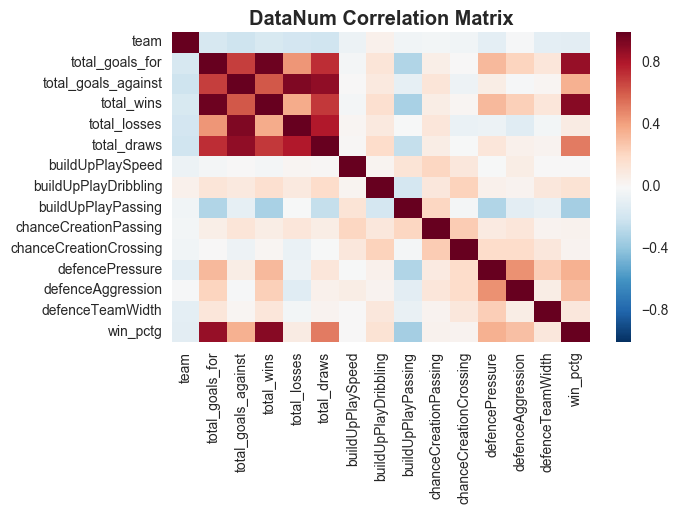

In [391]:
%matplotlib inline 
sns.heatmap(dataNum.corr())
plt.title('DataNum Correlation Matrix', fontweight= 'bold')

The usual suspects are correlated (goals, wins, win_pctg). We can now see if natural groups arise if we perform feature reduction followed by clustering.

## PCA

<a id='PCA'></a>

In [392]:
#Separate features from our target/response variable (win_pctg)
from sklearn import preprocessing

feats= dataNum.ix[:, dataNum.columns != 'team']
feats= feats.ix[:, feats.columns != 'win_pctg']
target= dataNum['win_pctg']

#Standardize the magnitude of the values in our feature set (essential for PCA)

featsScaled= preprocessing.scale(feats)

In [393]:
#Perform PCA, leaving only the features that account for 90% of variance
#Our fit will return our new PCA object which has our new feature
#matrix (eigenvectors) but also our list of variable importances
#(eigenvalue magnitudes)

from sklearn import decomposition

pca = decomposition.PCA(n_components=0.9)
pca.fit(featsScaled)

#Transform our data, After ranking the features by the magnitude of their eigenvalues (larger= lar)
pcaFeats = pca.transform(featsScaled)

In [394]:
print 'Dimensions before feature reduction: ', featsScaled.shape
print 'Dimensions after feature reduction: ', pcaFeats.shape

Dimensions before feature reduction:  (241, 13)
Dimensions after feature reduction:  (241, 8)


In [395]:
pcaFeats

array([[-0.96005902, -0.40238039, -0.58211212, ...,  0.11785062,
        -1.33828219,  0.02339903],
       [ 1.95961423, -0.03877514, -0.08957821, ..., -0.03033218,
         0.0441648 ,  0.24399346],
       [-1.467558  ,  1.48446128,  1.80623875, ...,  0.78068764,
         0.82871662, -0.14800102],
       ..., 
       [ 3.21217254,  0.95916734, -0.47775129, ...,  0.21029762,
        -0.34559688,  0.20131113],
       [ 3.48923596, -0.55119605, -1.2407987 , ..., -1.58375208,
        -0.6434792 ,  0.50153568],
       [ 2.65237101,  0.77420533,  1.03951517, ...,  0.4456845 ,
        -0.70526569, -0.59458279]])

## K-Means Clustering

<a id='K-Means Clustering'></a>

Now that we've reduced our feature space, let's see if we can find any way to segment our teams based on their transformed features. First we'll visualize our first two principal components plotted against one another.

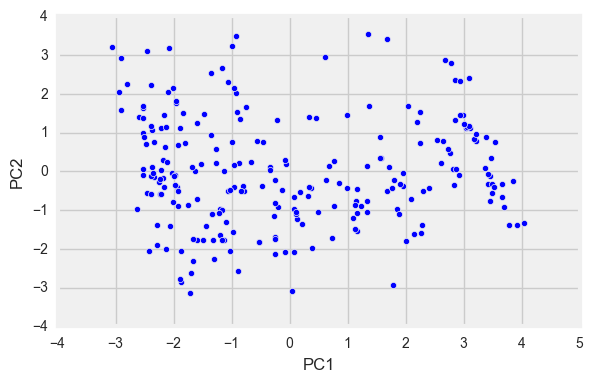

In [396]:
plt.scatter(pcaFeats[:,0], pcaFeats[:,1])
plt.xlabel('PC1')
plt.ylabel('PC2')

Excellent, the data seems randomly distributed. Now, as a first pass, let's try a k-means clustering algorithm to see if we can find clusters that naturally arise. Though we don't know the number of clusters to choose, let's see what happens if we start with k= 3.

In [397]:
from sklearn import cluster

k_means = cluster.KMeans(n_clusters=3)
k_means.fit(pcaFeats) 

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=3, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)

In [398]:
#Print out labels to see breakdown of labels
print k_means.labels_

[0 1 2 2 2 1 1 1 1 1 0 1 1 1 0 2 1 0 1 0 1 2 1 0 0 1 2 0 0 0 0 1 1 0 0 2 1
 1 1 0 2 1 0 1 2 1 1 2 0 1 0 2 1 1 1 1 2 0 0 1 1 1 0 1 0 0 0 1 1 0 1 0 0 1
 2 1 2 1 0 0 1 0 2 0 1 2 1 2 2 1 1 0 0 2 2 0 1 1 0 1 2 1 2 2 0 2 1 2 0 1 2
 2 2 2 2 2 1 2 0 1 1 0 0 0 2 2 0 1 2 0 2 2 0 1 1 2 2 2 2 1 0 2 2 0 0 1 0 0
 0 0 1 2 1 2 1 2 2 1 0 1 1 2 0 2 2 0 1 2 0 0 1 0 0 2 2 1 1 0 1 0 2 1 0 2 2
 0 1 1 1 2 0 2 0 2 2 1 0 0 2 2 0 1 0 0 0 1 2 2 0 2 2 0 2 2 0 2 0 0 0 0 2 0
 0 0 1 2 0 0 2 0 0 0 2 1 2 2 1 1 1 1 1]


Now let's copy our dataNum table and then join the team_names to it so we can keep track of the indices when we visualize our plots.

In [399]:
datanumLabels= dataNum.copy()
datanumLabels= pd.merge(datanumLabels, team_names, how='left',on='team')

We'll also try to see how the grouping corresponds to several obvious parameters: win percentage, total wins, total goals, goal chance creation crossing. The last one is included since it's the Fifa '15 parameter with the largest standard deviation and would be better at showing differences than other parameters.

In [400]:
win_pctg= 120*(datanumLabels['win_pctg'].values)/float(max(datanumLabels['win_pctg'].values))
total_wins= 120*(datanumLabels['total_wins'].values)/float(max(datanumLabels['total_wins'].values))
total_goals_for= 120*(datanumLabels['total_goals_for'].values)/float(max(datanumLabels['total_goals_for'].values))
chanceCreationCrossing= 120*(datanumLabels['chanceCreationCrossing'].values)/float(max(datanumLabels['chanceCreationCrossing'].values))
team_names= datanumLabels['team_long_name'].values

In [401]:
datanumLabels.head()

,team,total_goals_for,total_goals_against,total_wins,total_losses,total_draws,buildUpPlaySpeed,buildUpPlayDribbling,buildUpPlayPassing,chanceCreationPassing,chanceCreationCrossing,defencePressure,defenceAggression,defenceTeamWidth,win_pctg,team_long_name
0,1601,280,292,92,91,57,47,57,44,58,36,46,44,64,0.502083,Ruch Chorzów
1,1773,126,162,22,40,28,52,51,50,50,54,43,44,50,0.400000,Oud-Heverlee Leuven
2,1957,287,315,87,89,64,70,54,37,64,66,53,62,44,0.495833,Jagiellonia Białystok
3,2182,372,210,124,56,60,57,55,46,67,70,50,53,46,0.641667,Lech Poznań
4,2186,235,293,61,96,53,61,52,49,62,65,59,67,58,0.416667,Cracovia


In [402]:
#Let's assign cluster indices and labels to our three groups to keep track 
#of them when we visualize the subgroups in our pc1 vs pc2 plot

cluster0= []; indexCluster0= []
cluster1= []; indexCluster1= []
cluster2= []; indexCluster2= []

for i in range(0,len(k_means.labels_)):
    if k_means.labels_[i] == 0: 
        cluster0.append(pcaFeats[i,:])
        indexCluster0.append(i)
    elif k_means.labels_[i] == 1: 
        cluster1.append(pcaFeats[i,:])
        indexCluster1.append(i)
    elif k_means.labels_[i] == 2: 
        cluster2.append(pcaFeats[i,:])
        indexCluster2.append(i)

In [403]:
#Turn them to arrays to make them easier to work with

cluster0= np.array(cluster0)
cluster1= np.array(cluster1)
cluster2= np.array(cluster2)

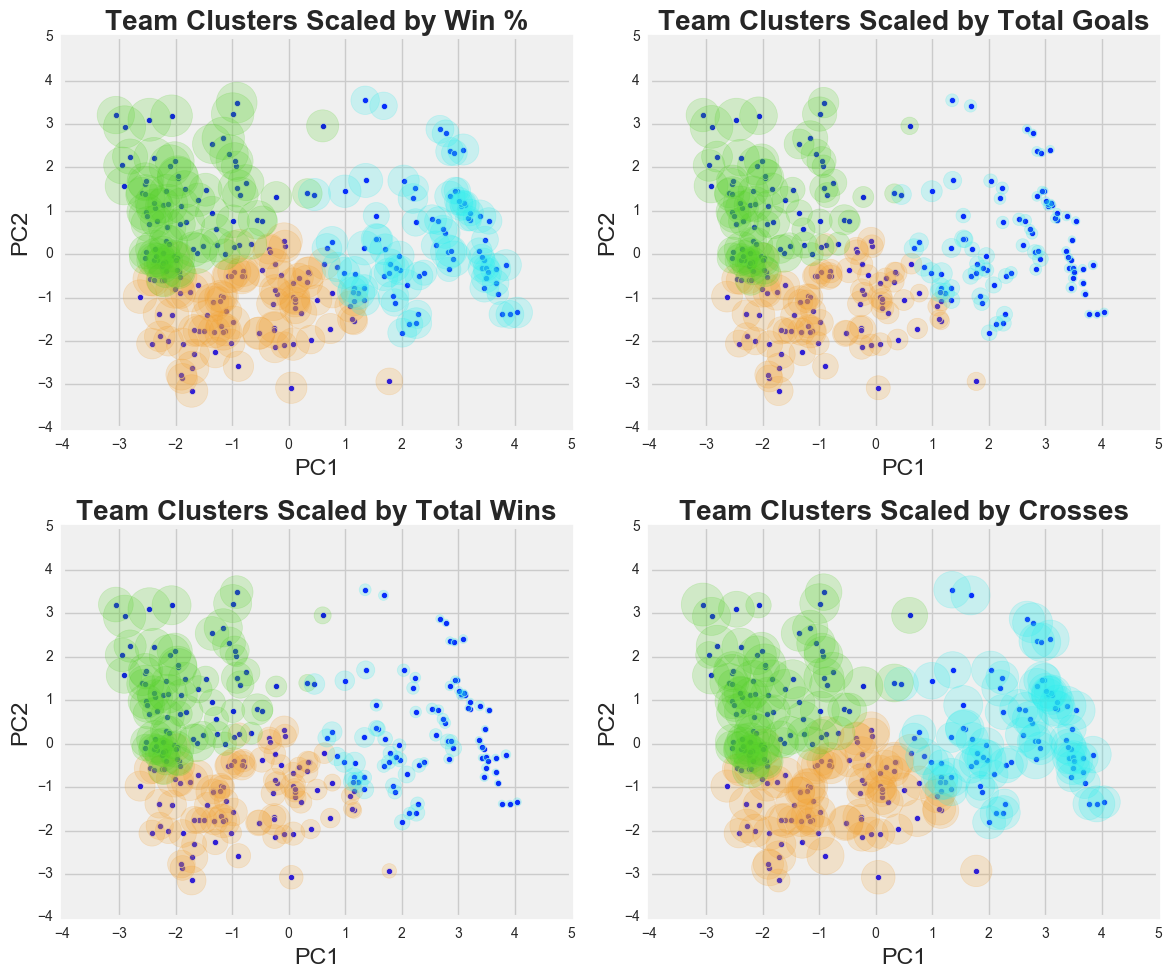

In [420]:
%matplotlib inline

clusters= [cluster0, cluster1, cluster2]
scales= [win_pctg, total_goals_for, total_wins,  chanceCreationCrossing]

titles= ['Team Clusters Scaled by Win %', 'Team Clusters Scaled by Total Goals',
         'Team Clusters Scaled by Total Wins', 'Team Clusters Scaled by Crosses']


plotIndices= [[2,2,1],[2,2,2],[2,2,3],[2,2,4]]

figure, ax = plt.subplots(1,1, figsize=(12,10))

for i in range(4):
    plt.style.use('fivethirtyeight')
    plt.subplot(2, 2, i+1)
    plt.scatter(pcaFeats[:,0], pcaFeats[:,1])
    plt.xlabel('PC1')
    plt.ylabel('PC2')

    plt.scatter(cluster0[:,0], cluster0[:,1], color= '#f2a02e', s= scales[i][indexCluster0]*8, alpha= 0.2) 
    plt.scatter(cluster1[:,0], cluster1[:,1], color= '#28eded', s= scales[i][indexCluster1]*8, alpha= 0.2)
    plt.scatter(cluster2[:,0], cluster2[:,1], color= '#54d127', s= scales[i][indexCluster2]*8, alpha= 0.2)
    
    plt.title(titles[i], fontweight= 'bold')
plt.tight_layout()

This looks great. Although the number of clusters (3) was arbitrary, we see that we have some natural groups that arise. If we scale the size of the markers based on one feature, we see that two of our features (Win % and crosses) don't appear to show much of a difference between groups. However, if we group them by total wins there's a noticeable difference between the three groups. 

In [405]:
#Let's see who belongs to these groups for highest scoring teams

print 'Cluster 0, Cluster 1, Cluster 2'
zip(datanumLabels.ix[indexCluster0].sort('total_goals_for', ascending= False).head(5)['team_long_name'],
datanumLabels.ix[indexCluster1].sort('total_goals_for', ascending= False).head(5)['team_long_name'], 
    datanumLabels.ix[indexCluster2].sort('total_goals_for', ascending= False).head(5)['team_long_name'])

Cluster 0, Cluster 1, Cluster 2


[(u'Manchester City', u'Southampton', u'FC Barcelona'),
 (u'Chelsea', u'PEC Zwolle', u'Real Madrid CF'),
 (u'FC Twente', u'Ross County FC', u'Celtic'),
 (u'Feyenoord', u'RC Celta de Vigo', u'FC Bayern Munich'),
 (u'SC Heerenveen', u'\xc9vian Thonon Gaillard FC', u'PSV')]

This is interesting, let's see if we can explore the segmentation with goals further. We'll make one super fancy, interactive plot so we can explore the subgroups more easily. We'll use the Bokeh package for this!

## Interactive Clustering Exploration

To make the Bokeh plot easier to make let's create a new dataframe with just the team names, goals for, and a scaled goals column for the marker size.

In [406]:
#Create new dataframe and add pc1, pc2, scaled columns, and clustering label columns
#FYI 80 is just an empirically tested multiplier to make markers easier to see
bokehGoals= datanumLabels[['team_long_name','total_goals_for']]
bokehGoals['group_label']= k_means.labels_
bokehGoals['pc1']= pcaFeats[:,0]
bokehGoals['pc2']= pcaFeats[:,1]
bokehGoals['scaled_goals_for']= bokehGoals['total_goals_for'].apply(
                            lambda x: np.float(x)/max(bokehGoals['total_goals_for'])*80)
bokehGoals.head(3)

,team_long_name,total_goals_for,group_label,pc1,pc2,scaled_goals_for
0,Ruch Chorzów,280,0,-0.960059,-0.402380,26.383981
1,Oud-Heverlee Leuven,126,1,1.959614,-0.038775,11.872792
2,Jagiellonia Białystok,287,2,-1.467558,1.484461,27.043581


In [419]:
#Extra interactive Bokeh Figure

from bokeh.plotting import figure, output_notebook, show, ColumnDataSource
from bokeh.models import HoverTool
from bokeh.models import NumeralTickFormatter

output_notebook()

#We'll now make the source for the info on our hover
#The important thing to note is that for each one of our clusters (3)
#we'll have identical fields except for the indices we call to only 
#SELECT a subset of the data points we want for each cluster

source0= ColumnDataSource(data= dict(
        x= bokehGoals[bokehGoals['group_label'] == 0]['pc1'], 
        y= bokehGoals[bokehGoals['group_label'] == 0]['pc2'],
        marker_size= bokehGoals[bokehGoals['group_label'] == 0]['scaled_goals_for'],
        goals= bokehGoals[bokehGoals['group_label'] == 0]['total_goals_for'],
        title= bokehGoals[bokehGoals['group_label'] == 0]['team_long_name']))

source1= ColumnDataSource(data= dict(
        x= bokehGoals[bokehGoals['group_label'] == 1]['pc1'], 
        y= bokehGoals[bokehGoals['group_label'] == 1]['pc2'],
        marker_size= bokehGoals[bokehGoals['group_label'] == 1]['scaled_goals_for'],
        goals= bokehGoals[bokehGoals['group_label'] == 1]['total_goals_for'],
        title= bokehGoals[bokehGoals['group_label'] == 1]['team_long_name']))

source2= ColumnDataSource(data= dict(
        x= bokehGoals[bokehGoals['group_label'] == 2]['pc1'], 
        y= bokehGoals[bokehGoals['group_label'] == 2]['pc2'],
        marker_size= bokehGoals[bokehGoals['group_label'] == 2]['scaled_goals_for'],
        goals= bokehGoals[bokehGoals['group_label'] == 2]['total_goals_for'],
        title= bokehGoals[bokehGoals['group_label'] == 2]['team_long_name']))

#Then, when we use the hover tool to bring up our info when we hover, 
#all of them will follow the @title and the @goals assignments even
#though the data will come FROM different sources (0,1,2) for each cluster

hover= HoverTool(tooltips= [("Team", " @title"), ('Goals Scored', ' @goals')])

#Initialize figure and define attributes
p = figure(plot_width=600, plot_height=500, tools=[hover, 'wheel_zoom', 'pan', 'reset'], 
           title= "Segmenting European Soccer Clubs", title_text_font_size='18pt')

#Plot a figure for each cluster, calling a different source for each cluster
p.circle('x', 'y', line_color= '#f2a02e', fill_color= '#f2a02e', fill_alpha= 0.3, source=source0,
                           line_width= 4, size= 'marker_size')
p.circle('x', 'y', line_color= '#30cbf2', fill_color= '#30cbf2', fill_alpha= 0.3, source=source1,
                           line_width= 4, size='marker_size')
p.circle('x', 'y', line_color= '#54d127', fill_color= '#54d127', fill_alpha= 0.3, source=source2,
                           line_width= 4, size='marker_size')

#Finally, plot a 'skeleton' scatter plot that draws centroid for all points
#without using a data source
p.circle(pcaFeats[:,0], pcaFeats[:,1], color= 'blue', size=3)

p.xaxis[0].formatter = NumeralTickFormatter(format="0")
p.yaxis[0].formatter = NumeralTickFormatter(format="0")

p.xaxis.axis_label = "Principal Component 1"
p.yaxis.axis_label = "Principal Component 2"
p.xaxis.axis_label_text_font_size = "12pt"
p.yaxis.axis_label_text_font_size = "12pt"

p.title_text_font_style = "bold"

show(p)

Loading BokehJS ...

Now that we have the segmentation and the scaling on one figure we can try to explore how strong the total goals scored feature is. 

At first glance it may seem like total goals for segments these groups almost perfectly. However, we have some large goal scorers in the orange group (see Chelsea) that are bigger than points in the blue group. We can explore the differences between these different groups a little more closely with histograms where we clump everyone together and then separate them into their segmented groups. If total goals by itself is good enough at separating these groups, we should see this show up in the histogram (else it may only be a strong contributing factor to the segmentation). 

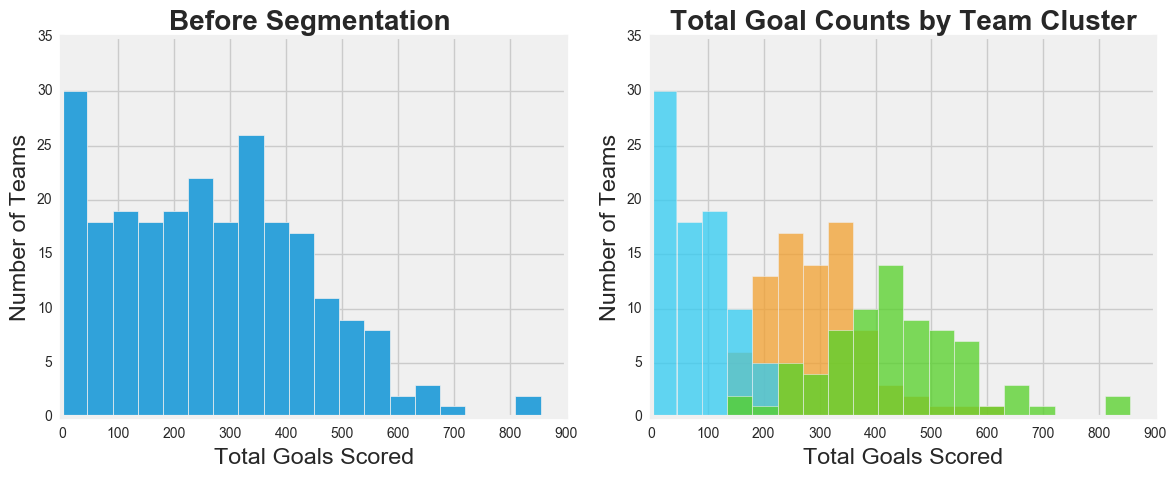

In [431]:
histBins= 20

figure, ax = plt.subplots(1,1, figsize=(12,5), facecolor='white')

plt.subplot(1,2,1)
plt.hist(bokehGoals['total_goals_for'], histBins, range= (0,900))
plt.xlabel('Total Goals Scored')
plt.ylabel('Number of Teams')
plt.ylim([0, 35])
plt.title('Before Segmentation ', fontweight= 'bold')

plt.subplot(1,2,2)
plt.hist(bokehGoals[bokehGoals['group_label'] == 0]['total_goals_for'], histBins, range=(0,900), alpha= 0.75, color= '#f2a02e')
plt.hist(bokehGoals[bokehGoals['group_label'] == 1]['total_goals_for'], histBins, range=(0,900), alpha= 0.75, color= '#30cbf2')
plt.hist(bokehGoals[bokehGoals['group_label'] == 2]['total_goals_for'], histBins, range=(0,900), alpha= 0.75, color= '#54d127')
plt.xlabel('Total Goals Scored')
plt.ylabel('Number of Teams')
plt.ylim([0, 35])
plt.title('Total Goal Counts by Team Cluster', fontweight= 'bold')

plt.tight_layout()

This is great. On the left we see that there are possibly two groups for sure, but a third one becomes somewhat obscured by the overlap in the groups. After segmenting the groups though we see that we can observe the overlap, but clearly see that there are three distinct groups as a result of our PCA/K-means clustering step.

## Measuring the Performance of Segmentation

How good is our segmentation? Since clustering is an unsupervised machine learning method, we may not know the correct answer. However, there are metrics we can use to determine how well our model performed. One metric is the sum of squared errors, or the sum of distances of each point to its centroid for all clusters in our data. In SK Learn, this metric is called the <strong>inertia</strong>. 

We can rerun the segmentation on our data with different cluster values and determine where our choice of three fits among all values.

In [432]:
#Initialize cluster values and inertia score list
clusters= []
inertiaList= []
for i in range(1,30,1):
    k_means = cluster.KMeans(n_clusters=i)
    k_means.fit(pcaFeats)
    clusters.append(i)
    inertiaList.append(k_means.inertia_)
    

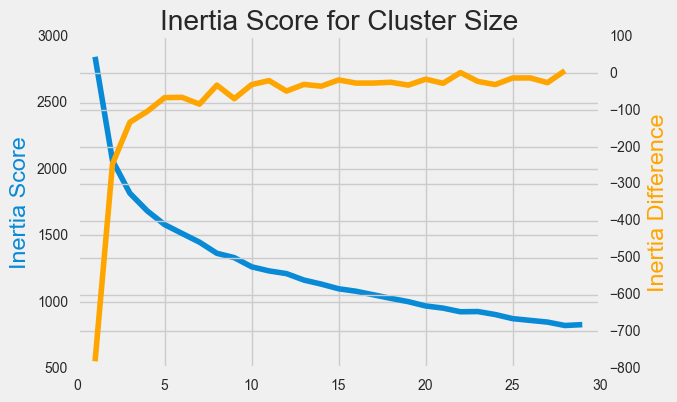

In [433]:
#Plot inertia score and difference of adjacent scores

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()

ax1.plot(clusters,inertiaList, color= '#088ad7')
#ax1.scatter(clusters[1],inertiaList[1], color= 'r', s= 50, alpha= 0.5)

ax2.plot(clusters[:len(clusters)-1],np.diff(inertiaList), 'orange')

ax1.set_ylabel('Inertia Score', color='#088ad7')
ax2.set_ylabel('Inertia Difference', color='orange')

plt.xlabel('Number of Clusters')
plt.title('Inertia Score for Cluster Size')

One method for determining the best choice for K is using the <strong>Elbow Method</strong> where we observe the largest change in inertia for a given value of K. In our figure above it appears to be K= 2, which might make sense since the separation between our groups (at least from our pc1 vs pc2 plot) was less well separated. 

That said, the separation for K = 2 is not great. We'll analyze this more closely, but the dataset may not be large segment the teams well enough. If we consolidate the data from multiple seasons, this may improve.

Now I'm gonna get the code to embed the bokeh figure into an html page. This code will return a javascript file and a div line that I can use to position my figure in the html page.

In [270]:
from bokeh.embed import components
script, div = components(p)

print div

f=open('fifa_bokeh_segment.js', 'w')
f.write(script)
f.close()


<div class="bk-root">
    <div class="plotdiv" id="86daf87b-ed6b-429f-b7b5-da62fb5eeec8"></div>
</div>
